Calling All Autobots

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import exposure

Function for histogram matching

In [2]:
# Function for histogram matching
def histogram_matching(source, template):
    matched = exposure.match_histograms(source, template, channel_axis=None)
    return matched

Dataset

In [3]:
#Data training
image1 = 'Images/training/drishtiGS_017.png'
image2 = 'Images/training/drishtiGS_032.png'
image3 = 'Images/training/drishtiGS_036.png'
image4 = 'Images/training/drishtiGS_037.png'
image5 ='Images/training/drishtiGS_040.png'
image6 = 'Images/training/drishtiGS_042.png'
image7 = 'Images/training/drishtiGS_049.png'
image8 = 'Images/training/drishtiGS_057.png'
image9 = 'Images/training/drishtiGS_060.png'
image10 = 'Images/training/drishtiGS_063.png'
image11 = 'Images/training/drishtiGS_064.png'
image12 = 'Images/training/drishtiGS_066.png'
image13 = 'Images/training/drishtiGS_068.png'
image14 = 'Images/training/drishtiGS_069.png'
image15 = 'Images/training/drishtiGS_080.png'
image16 = 'Images/training/drishtiGS_081.png'
image17 = 'Images/training/drishtiGS_084.png'
image18 = 'Images/training/drishtiGS_088.png'
image19 = 'Images/training/drishtiGS_094.png'
image20 = 'Images/training/drishtiGS_098.png'

#Data Testing
image21 = 'Images/testing/drishtiGS_033.png'
image22 = 'Images/testing/drishtiGS_038.png'
image23 = 'Images/testing/drishtiGS_041.png'
image24 = 'Images/testing/drishtiGS_046.png'
image25 = 'Images/testing/drishtiGS_051.png'
image26 = 'Images/testing/drishtiGS_058.png'
image27 = 'Images/testing/drishtiGS_076.png'
image28 = 'Images/testing/drishtiGS_089.png'
image29 = 'Images/testing/drishtiGS_090.png'
image30 = 'Images/testing/drishtiGS_092.png'


# Buat list yang berisi semua variabel gambar
images = [
    image1, image2, image3, image4, image5,
    image6, image7, image8, image9, image10,
    image11, image12, image13, image14, image15,
    image16, image17, image18, image19, image20,
    image21, image22, image23, image24, image25,
    image26, image27, image28, image29, image30
]

Read reference image

In [4]:
# Read reference image and input image
reference_image_path = 'Images/training/drishtiGS_037.png'
# Load the images
reference_image = cv2.imread(reference_image_path)
# Convert images to grayscale
gray_reference = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)


Iterasi 20 Gambar untuk dapat ROI

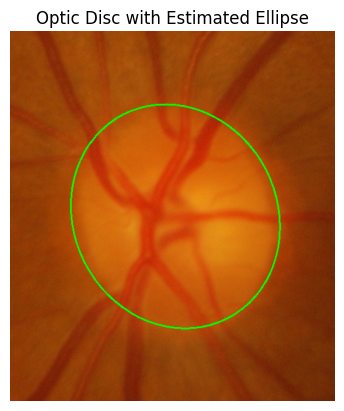

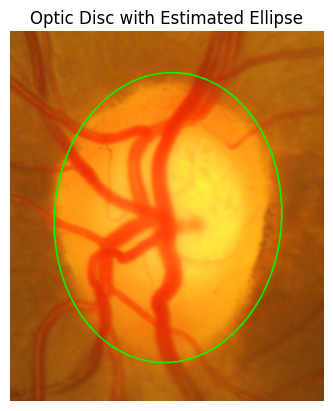

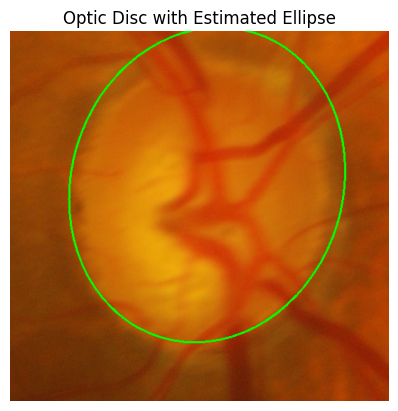

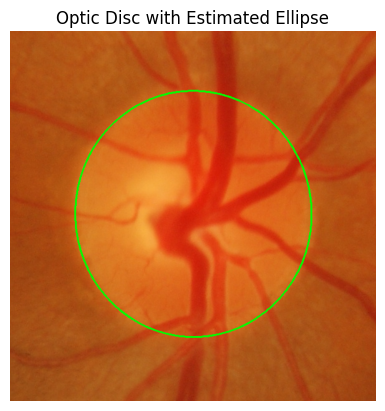

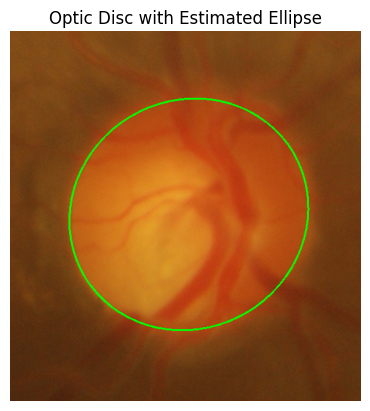

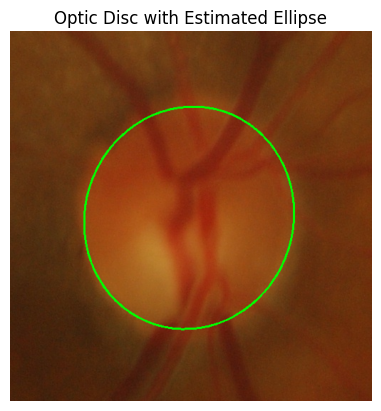

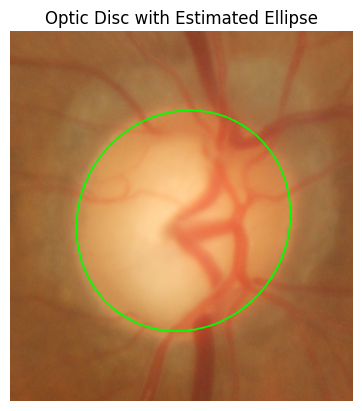

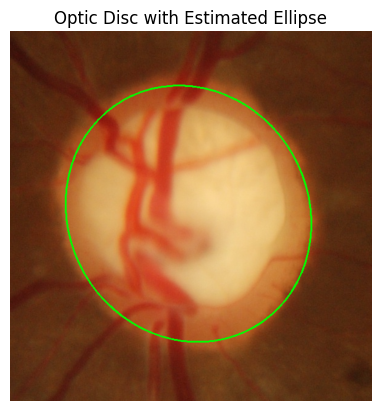

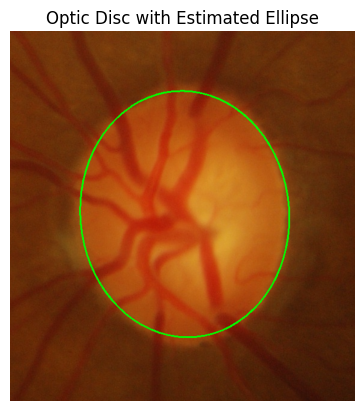

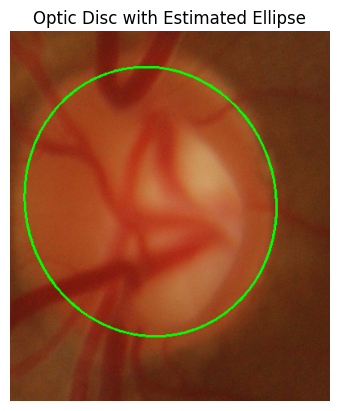

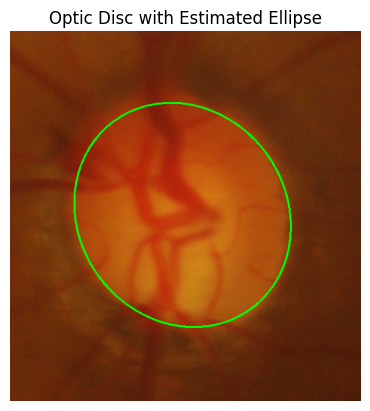

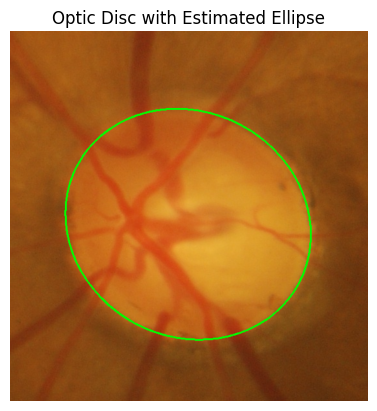

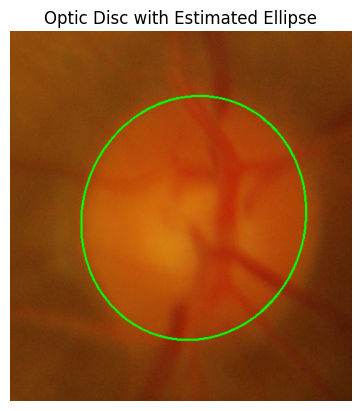

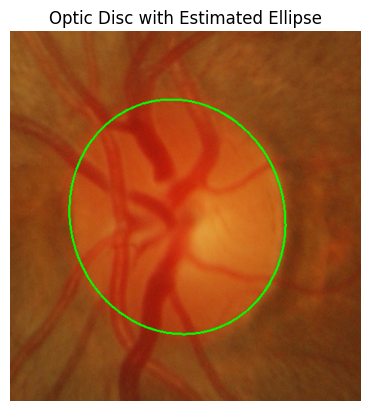

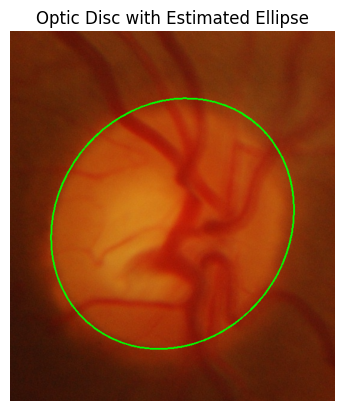

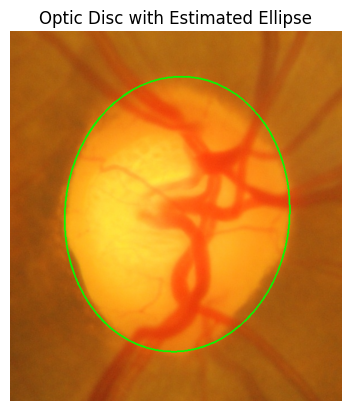

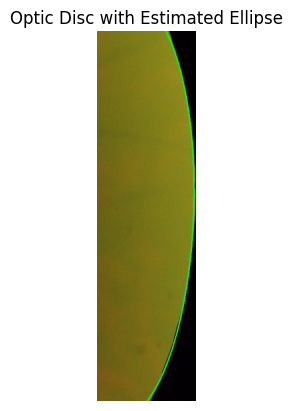

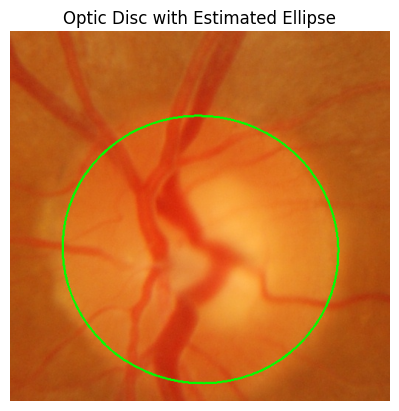

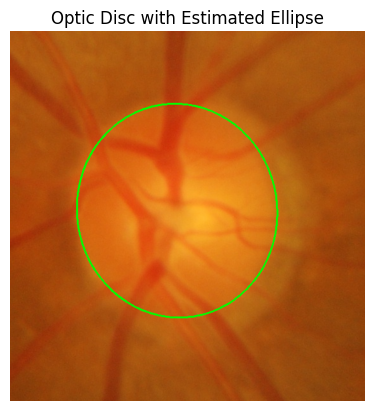

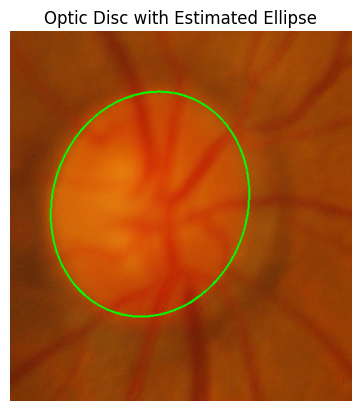

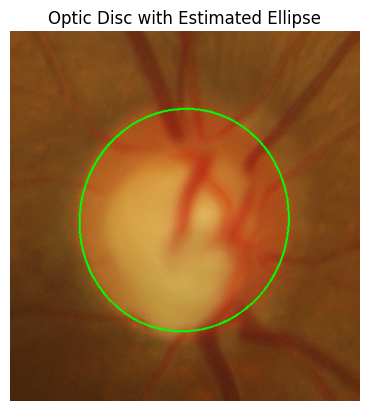

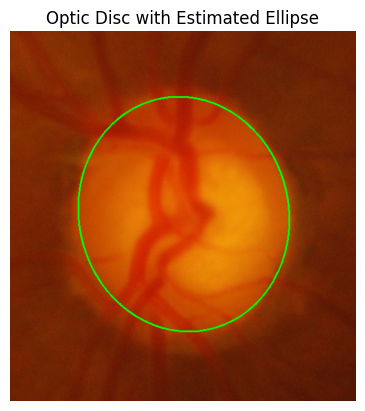

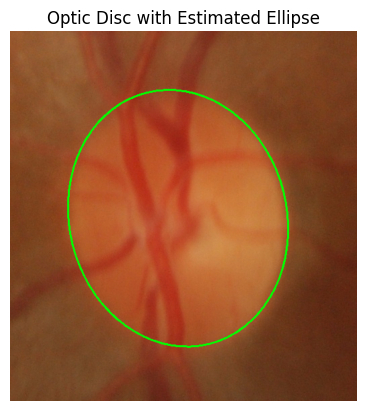

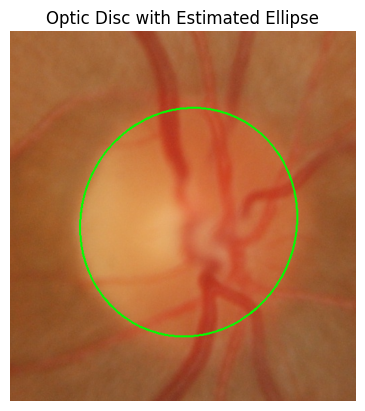

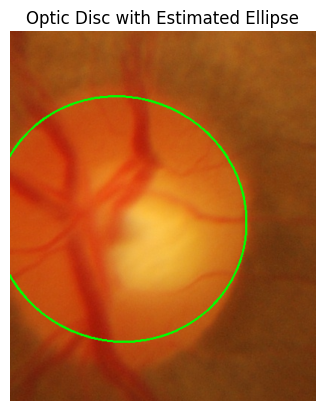

In [5]:
for image in images:
    fundus_image = cv2.imread(image)

    gray_image = cv2.cvtColor(fundus_image, cv2.COLOR_BGR2GRAY)
    # Perform histogram matching
    matched_image = histogram_matching(gray_image, gray_reference)
    # Get the dimensions of the image
    height, width, _ = fundus_image.shape

    # Crop the image along the y-axis from 550 to 1300
    # Taking the entire width for x-axis
    fundus_cropped = matched_image[550:1300, 0:width]
    RGB_cropped = fundus_image[550:1300, 0:width]

    # Apply thresholding
    _, binary_image = cv2.threshold(fundus_cropped, 100, 255, cv2.THRESH_BINARY)
    # Perform morphological opening
    kernel_open = np.ones((20, 20), np.uint8)
    opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel_open)
    # Perform morphological closing
    kernel_close = np.ones((100, 100), np.uint8)
    closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel_close)
    
    # Convert closed_image to grayscale if it's not already in grayscale
    if len(closed_image.shape) > 2:
        closed_image_gray = cv2.cvtColor(closed_image, cv2.COLOR_BGR2GRAY)
    else:
        closed_image_gray = closed_image

    # Ensure the image is in the correct format (CV_8UC1)
    closed_image_uint8 = np.uint8(closed_image_gray)
    # Find contours
    contours, _ = cv2.findContours(closed_image_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours were found
    if not contours:
        raise ValueError("No contours found in the image")

    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Fit ellipse ke kontur terbesar
    if len(largest_contour) >= 5:  # Minimum number of points required to fit ellipse
        ellipse = cv2.fitEllipse(largest_contour)
        
        # Get the parameters of the ellipse
        (center, axes, angle) = ellipse
        center_x, center_y = center
        width, height = axes

        # Calculate bounding box of the ellipse
        x1 = int(center_x - width // 2)-100
        x2 = int(center_x + width // 2)+100
        y1 = int(center_y - height // 2)-100
        y2 = int(center_y + height // 2)+100

        # Ensure the crop area is within the image bounds
        y1, y2 = max(0, y1), min(fundus_cropped.shape[0], y2)
        x1, x2 = max(0, x1), min(fundus_cropped.shape[1], x2)

        # Crop the image to the bounding box of the ellipse
        optic_disc_cropped = fundus_cropped[y1:y2, x1:x2]
        optic_disc_RGB = RGB_cropped[y1:y2, x1:x2]

        # Convert RGB_cropped to RGB format
        color_image = cv2.cvtColor(RGB_cropped, cv2.COLOR_BGR2RGB)

        # Draw ellipse on the color image
        cv2.ellipse(color_image, ellipse, (0, 0, 255), 2)

    else:
        print("Kontur tidak cukup poin untuk fitting ellips.")
    
    # Pisahkan gambar menjadi tiga komponen warna
    B, G, R = cv2.split(optic_disc_RGB)
    
    # Fungsi untuk menampilkan gambar menggunakan matplotlib
    def show_image(title, img):
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')

    # Konversi B, G, R dari format OpenCV (BGR) ke format yang bisa ditampilkan matplotlib (RGB)
    # Untuk itu, kita perlu mengatur R, G, B ke channel-nya masing-masing di gambar RGB.
    zeros = np.zeros_like(B)  # array dengan nilai nol untuk channel lain
    R_img = cv2.merge([zeros, zeros, R])  # Hanya komponen merah
    G_img = cv2.merge([zeros, G, zeros])  # Hanya komponen hijau
    B_img = cv2.merge([B, zeros, zeros])  # Hanya komponen biru

    # Calculate the histogram for each channel (B, G, R)
    hist_b = cv2.calcHist([optic_disc_RGB], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([optic_disc_RGB], [1], None, [256], [0, 256])
    hist_r = cv2.calcHist([optic_disc_RGB], [2], None, [256], [0, 256])

    # Hitung nilai minimum dan maksimum dari setiap saluran warna
    min_r, max_r = np.min(R), np.max(R)

    # Lakukan kontras stretching pada saluran merah
    r_stretched = ((R - min_r) / (max_r - min_r)) * 255
    r_stretched = np.uint8(r_stretched)

    # Gabungkan kembali saluran warna merah yang telah dimodifikasi dengan saluran hijau dan biru yang kosong
    stretched_img = cv2.merge((zeros, zeros, r_stretched))

    # Stretched hist
    hist_stretch = cv2.calcHist([r_stretched], [0], None, [256], [0, 256])
    
    # Pisahkan citra menjadi tiga kanal: B, G, R
    b, g, r = cv2.split(stretched_img)

    # Buat mask berdasarkan kondisi threshold pada kanal merah
    mask = r < 150

    # Set nilai pada mask menjadi 0 pada kanal merah
    r[mask] = 0

    # Gabungkan kembali kanal B, G, R menjadi citra RGB
    pass_if_img = cv2.merge([b, g, r])
    pass_if_img_r = cv2.calcHist([pass_if_img], [2], None, [256], [0, 256])

    # Perform morphological closing
    kernel_close = np.ones((30,30),np.uint8)
    closed_image = cv2.morphologyEx(pass_if_img, cv2.MORPH_CLOSE, kernel_close)

    # Convert closed_image to grayscale if it's not already in grayscale
    if len(closed_image.shape) > 2:
        closed_image_gray = cv2.cvtColor(closed_image, cv2.COLOR_BGR2GRAY)
    else:
        closed_image_gray = closed_image

    # Ensure the image is in the correct format (CV_8UC1)
    closed_image_uint8 = np.uint8(closed_image_gray)
    # Find contours
    contours, _ = cv2.findContours(closed_image_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours were found
    if not contours:
        raise ValueError("No contours found in the image")

    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Fit ellipse ke kontur terbesar
    if len(largest_contour) >= 5:  # Minimum number of points required to fit ellipse
        ellipse = cv2.fitEllipse(largest_contour)
    
        # Gambar ellips yang diperkirakan di atas citra RGB
        optic_disc_with_ellipse = cv2.ellipse(optic_disc_RGB, ellipse, (0, 255, 0), 2)

        # Tampilkan citra dengan ellips yang diperkirakan
        plt.imshow(cv2.cvtColor(optic_disc_with_ellipse, cv2.COLOR_BGR2RGB))
        plt.title("Optic Disc with Estimated Ellipse")
        plt.axis('off')
        plt.show()
    
    else:
        print("Kontur tidak cukup poin untuk fitting ellips.")